In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

from dataset.transformers_dataset import load_data
from metrics.auc import k_fold_roc_curve, godbole_accuracy

# Data loading

In [2]:
sns.set_theme("notebook", "whitegrid")

In [3]:
df = load_data("multi_label_dataset.csv", "articles", False)

In [4]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
X = vectorizer.fit_transform(df["Text"])
vectorizer.get_feature_names_out()

c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array(['0', '00', '000', ..., '中国体育', '白鹿视频', '陳奕迅'], dtype=object)

In [5]:
X.shape

(166, 11028)

In [6]:
y = df[df.columns[2:-1]].to_numpy()

In [7]:
y

array([[1, 1, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

# Multilabel Classification

In [3]:
%load_ext autoreload
%autoreload 2

In [8]:
from functools import partial
from typing import Callable

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, average_precision_score,
                             coverage_error, f1_score,
                             label_ranking_average_precision_score,
                             label_ranking_loss, multilabel_confusion_matrix,
                             precision_score, recall_score, roc_auc_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [9]:
NUM_FOLDS = 5

In [10]:
mskf = MultilabelStratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

In [11]:
results = {}

In [12]:
def train_and_eval(
    mskf: MultilabelStratifiedKFold, model_class: Callable, X: np.ndarray, y: np.ndarray
) -> dict[str, float]:
    """Train and evaluate a model using MultilabelStratifiedKFold cross-validation.

    Args:
        mskf (MultilabelStratifiedKFold): MultilabelStratifiedKFold object
        model_class (Callable): Class of the model to be trained
        X (np.ndarray): Dataset of input features
        y (np.ndarray): Dataset of target labels

    Returns:
        dict[str, float]: Dictionary of metrics
    """
    print(f"Model type: {model_class.__name__}")

    # Initialize lists to store metrics
    accs, lraps, f1s, lrls, precs, recs, specs, cov_errs, aurocs, aps, godbole_accs, fill_rate_preds = (
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        []
    )
    y_preds, y_probs, y_tests = [], [], []

    for i, (train_idx, test_idx) in enumerate(mskf.split(X, y)):
        # Split the dataset into training and testing sets
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize and fit the model to training data
        model = model_class()
        model.fit(X_train, y_train)

        # Retrieve the predicted probabilities and labels
        y_prob = np.array(model.predict_proba(X_test))
        if not model_class.__name__ == "MLPClassifier":
            y_prob = y_prob[:, :, 1].reshape(len(y_test), -1)
        y_pred = model.predict(X_test)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        godbole_acc = godbole_accuracy(y_test, y_pred, "macro")
        godbole_chance_acc = godbole_accuracy(y_test, np.ones_like(y_test), "macro")
        cov_error = coverage_error(y_test, y_prob)
        f1 = f1_score(y_test, y_pred, average="micro")
        lrap = label_ranking_average_precision_score(y_test, y_prob)
        lrl = label_ranking_loss(y_test, y_prob)
        prec = precision_score(y_test, y_pred, average="micro")
        rec = recall_score(y_test, y_pred, average="micro")
        y_test_inv = 1 - y_test
        y_pred_inv = 1 - y_pred
        spec = recall_score(y_test_inv, y_pred_inv, average="micro")
        ap_chance_level = y_test.sum() / y_test.size # Chance level for AP
        mlm = multilabel_confusion_matrix(y_test, y_pred)
        auroc = roc_auc_score(y_test, y_prob, average="micro")
        ap = average_precision_score(y_test, y_prob, average="micro")

        # Append metrics to lists
        accs.append(acc)
        godbole_accs.append(godbole_acc)
        lraps.append(lrap)
        f1s.append(f1)
        lrls.append(lrl)
        precs.append(prec)
        recs.append(rec)
        specs.append(spec)
        cov_errs.append(cov_error)
        y_preds.append(y_pred)
        y_probs.append(y_prob)
        y_tests.append(y_test)
        aurocs.append(auroc)
        aps.append(ap)
        fill_rate = np.sum(y_test) / y_test.size
        fill_rate_pred = np.sum(y_pred) / y_pred.size
        fill_rate_preds.append(fill_rate_pred)

        # Print metrics
        print(f"Fold: {i + 1}")
        print(
            f"acc: {acc:.4f}",
            f"godbole_acc: {godbole_acc:.4f} / {godbole_chance_acc:.4f} (chance)",
            f"lrap: {lrap:.4f} / {ap_chance_level:.4f} (chance)",
            f"f1: {f1:.4f}",
            f"lrl: {lrl:.4f}",
            f"rec: {rec:.4f}",
            f"prec: {prec:.4f}",
            f"spec: {spec: 4f}",
            f"cov_err: {cov_error:.4f}",
            f"auroc: {auroc:.4f}",
            f"ap: {ap:.4f}",
            f"fill_rate_pred: {fill_rate_pred:.4f} / {fill_rate:.4f} (true)",
            sep="\n",
            end="\n\n",
        )

    # Return metrics as a dictionary
    return {
        "acc": accs,
        "godbole_accs": godbole_accs,
        "f1": f1s,
        "rec": recs,
        "prec": precs,
        "spec": specs,
        "lrap": lraps,
        "lrl": lrls,
        "cov_err": cov_errs,
        "auroc": aurocs,
        "ap": aps,
        "fill_rate_preds": fill_rate_preds,
        "y_pred": y_preds,
        "y": y_tests,
        "y_prob": y_probs,
        "mlm": mlm,
    }

In [13]:
for model in [RandomForestClassifier, KNeighborsClassifier, DecisionTreeClassifier, MLPClassifier]:
    res = train_and_eval(mskf, model, X, y)
    results[model.__name__]= res

for model, res in results.items():
    print("\n")
    print("=" * 80)
    print(f"model: {model}")
    print(
        f"acc: {np.mean(res['acc']):.4f} +/- {np.std(res['acc']):.4f}",
        f"godbole_acc: {np.mean(res['godbole_accs']):.4f} +/- {np.std(res['godbole_accs']):.4f} / {godbole_accuracy(y, np.ones_like(y), "macro"):.4f} (chance level)",
        f"rec: {np.mean(res['rec']):.4f} +/- {np.std(res['rec']):.4f}",
        f"prec: {np.mean(res['prec']):.4f} +/- {np.std(res['prec']):.4f}",
        f"spec: {np.mean(res['spec']):.4f} +/- {np.std(res['spec']):.4f}",
        f"f1: {np.mean(res['f1']):.4f} +/- {np.std(res['f1']):.4f}",
        f"lrap: {np.mean(res['lrap']):.4f} +/- {np.std(res["lrap"]):.4f} / {y.sum() / y.size:.4f} (chance level)",
        f"lrl: {np.mean(res['lrl']):.4f} +/- {np.std(res['lrl']):.4f}",
        f"cov_err: {np.mean(res['cov_err']):.4f} +/- {np.std(res['cov_err']):.4f}",
        f"auroc: {np.mean(res['auroc']):.4f} +/- {np.std(res['auroc']):.4f}",
        f"ap: {np.mean(res['ap']):.4f} +/- {np.std(res['ap']):.4f} / {average_precision_score(y, np.ones_like(y), average='macro'):.4f} (chance level)",
        f"fill_rate_pred: {np.mean(res['fill_rate_preds']):.4f} +/- {np.std(res['fill_rate_preds']):.4f} / {np.sum(y) / y.size:.4f} (true fill rate)",
        "=" * 80,
        sep="\n",
        end="\n",
    )

best_model = max(results.items(), key=lambda x: x[1]["f1"])
print(f"Best model: {best_model[0]}, F1: {np.mean(best_model[1]['f1']):.4f}")

Model type: RandomForestClassifier
Fold: 1
acc: 0.6176
godbole_acc: 0.7868 / 0.7868 (chance)
lrap: 0.8265 / 0.7868 (chance)
f1: 0.8807
lrl: 0.1996
rec: 1.0000
prec: 0.7868
spec:  0.000000
cov_err: 7.5000
auroc: 0.4600
ap: 0.7849
fill_rate_pred: 1.0000 / 0.7868 (true)

Fold: 2
acc: 0.6176
godbole_acc: 0.7745 / 0.7721 (chance)
lrap: 0.8042 / 0.7721 (chance)
f1: 0.8750
lrl: 0.2391
rec: 1.0000
prec: 0.7778
spec:  0.032258
cov_err: 7.5000
auroc: 0.4101
ap: 0.7168
fill_rate_pred: 0.9926 / 0.7721 (true)

Fold: 3
acc: 0.7097
godbole_acc: 0.8468 / 0.8710 (chance)
lrap: 0.8788 / 0.8710 (chance)
f1: 0.9170
lrl: 0.1704
rec: 0.9722
prec: 0.8678
spec:  0.000000
cov_err: 7.8710
auroc: 0.5128
ap: 0.8811
fill_rate_pred: 0.9758 / 0.8710 (true)

Fold: 4
acc: 0.6667
godbole_acc: 0.8030 / 0.8030 (chance)
lrap: 0.8480 / 0.8030 (chance)
f1: 0.8908
lrl: 0.1463
rec: 1.0000
prec: 0.8030
spec:  0.000000
cov_err: 7.2424
auroc: 0.5681
ap: 0.8326
fill_rate_pred: 1.0000 / 0.8030 (true)

Fold: 5
acc: 0.6471
godbole_a

c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 1
acc: 0.5294
godbole_acc: 0.7500 / 0.7868 (chance)
lrap: 0.8822 / 0.7868 (chance)
f1: 0.8571
lrl: 0.1177
rec: 0.9533
prec: 0.7786
spec:  0.000000
cov_err: 6.9118
auroc: 0.5925
ap: 0.8603
fill_rate_pred: 0.9632 / 0.7868 (true)



c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 2
acc: 0.5294
godbole_acc: 0.7194 / 0.7721 (chance)
lrap: 0.8460 / 0.7721 (chance)
f1: 0.8423
lrl: 0.1380
rec: 0.9286
prec: 0.7708
spec:  0.064516
cov_err: 7.1471
auroc: 0.4961
ap: 0.7739
fill_rate_pred: 0.9301 / 0.7721 (true)



c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 3
acc: 0.6452
godbole_acc: 0.8145 / 0.8710 (chance)
lrap: 0.9404 / 0.8710 (chance)
f1: 0.8969
lrl: 0.0539
rec: 0.9259
prec: 0.8696
spec:  0.062500
cov_err: 7.3548
auroc: 0.6115
ap: 0.9189
fill_rate_pred: 0.9274 / 0.8710 (true)



c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold: 4
acc: 0.5758
godbole_acc: 0.7392 / 0.8030 (chance)
lrap: 0.8787 / 0.8030 (chance)
f1: 0.8553
lrl: 0.1021
rec: 0.9198
prec: 0.7992
spec:  0.057692
cov_err: 7.1212
auroc: 0.5059
ap: 0.8092
fill_rate_pred: 0.9242 / 0.8030 (true)

Fold: 5
acc: 0.5294
godbole_acc: 0.7647 / 0.7831 (chance)
lrap: 0.8714 / 0.7831 (chance)
f1: 0.8655
lrl: 0.1028
rec: 0.9671
prec: 0.7833
spec:  0.033898
cov_err: 7.0294
auroc: 0.5031
ap: 0.7805
fill_rate_pred: 0.9669 / 0.7831 (true)



model: RandomForestClassifier
acc: 0.6517 +/- 0.0344
godbole_acc: 0.7988 +/- 0.0257 / 0.8020 (chance level)
rec: 0.9944 +/- 0.0111
prec: 0.8037 +/- 0.0331
spec: 0.0065 +/- 0.0129
f1: 0.8884 +/- 0.0153
lrap: 0.8348 +/- 0.0263 / 0.8020 (chance level)
lrl: 0.1888 +/- 0.0309
cov_err: 7.5168 +/- 0.2017
auroc: 0.4985 +/- 0.0569
ap: 0.8030 +/- 0.0543 / 0.8020 (chance level)
fill_rate_pred: 0.9937 +/- 0.0094 / 0.8020 (true fill rate)


model: KNeighborsClassifier
acc: 0.5563 +/- 0.0676
godbole_acc: 0.7635 +/- 0.0421 / 0.8020 (chance

c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# DL Training

In [14]:
import math

import torch
import torch.nn.functional as F
import scipy
from torch import nn

from models.tfidf_attention import TfIdfAttention, TfIdfDense
from dataset.tfidf import TfIdfDataset

In [15]:
from torch.utils.data import DataLoader, Subset

from models.learner import (AccuracyCallback, F1Callback, Learner,
                            ModelProgressCallback, PlotGraphCallback,
                            SaveModelCallback)

In [45]:
NUM_HEADS = 12
# BATCH_SIZE = 1
BATCH_SIZE = 32
NUM_EPOCHS = 50
THRESHOLD = 0.85

In [17]:
ds = TfIdfDataset("multi_label_dataset.csv", "articles", False)
PADDED_SIZE = math.ceil(ds.X[0].shape[1] / NUM_HEADS) * NUM_HEADS
ds.set_padded_shape((0, PADDED_SIZE))

c:\Users\chris\.virtualenvs\AAI3003_Project-iSI0Dnoj\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [18]:
PADDED_SIZE

10008

In [19]:
model_partial = partial(
    TfIdfDense,
    n_inputs=PADDED_SIZE,
    n_outputs=len(ds.df.columns[2:-1]),
    hidden_size=[32, 64, 32],
    dropout=0.2
)

In [46]:
def train_and_eval_pytorch(
    mskf: MultilabelStratifiedKFold, model: partial, model_name: str, ds: TfIdfDataset
) -> dict[str, float]:
    """Train and evaluate a model using MultilabelStratifiedKFold cross-validation.

    Args:
        mskf (MultilabelStratifiedKFold): MultilabelStratifiedKFold object
        model_class (Callable): Class of the model to be trained
        X (np.ndarray): Dataset of input features
        y (np.ndarray): Dataset of target labels

    Returns:
        dict[str, float]: Dictionary of metrics
    """
    print(f"Model type: {model_name}")
    # Initialize lists to store metrics
    (
        accs,
        lraps,
        f1s,
        lrls,
        precs,
        recs,
        specs,
        cov_errs,
        aurocs,
        aps,
        godbole_accs,
        fill_rate_preds,
    ) = ([], [], [], [], [], [], [], [], [], [], [], [])
    y_preds, y_probs, y_tests = [], [], []

    for i, (train_idx, test_idx) in enumerate(mskf.split(ds.X, ds.y)):
        # Split the dataset into training and testing sets
        train_ds = Subset(ds, train_idx)
        test_ds = Subset(ds, test_idx)
        train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

        # Initialize and fit the model to training data
        model_instance = model()
        learner = Learner(
            model_instance,
            nn.BCEWithLogitsLoss(),
            torch.device("cuda"),
            cbs=[
                F1Callback(),
                PlotGraphCallback(),
                SaveModelCallback(
                    model=model_instance,
                    strategy="best",
                    root_dir=f"ckpts/{model_name}/fold_{i}",
                    model_pth="model_best.pth",
                    metric="valid_loss",
                ),
                ModelProgressCallback(["accuracy", "f1"]),
            ],
            metrics=[
                F1Callback(multilabel=True),
                AccuracyCallback(threshold=THRESHOLD, multilabel=True),
            ],
        )
        learner.fit(train_dl, test_dl, NUM_EPOCHS)

        # Retrieve the predicted probabilities and labels
        losses, y_prob, y_test = learner.evaluate(test_dl)
        best_thresh = 0
        max_f1 = 0.0
        for thresh in sorted(y_prob.flatten()):
            y_pred = (y_prob > thresh).astype(int)
            f1 = f1_score(y_test, y_pred, average="samples")
            if f1 > max_f1:
                max_f1 = f1
                best_thresh = thresh
        y_pred = (y_prob > best_thresh).astype(int)
        y_test = y_test.astype(int)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        godbole_acc = godbole_accuracy(y_test, y_pred, "macro")
        godbole_chance_acc = godbole_accuracy(y_test, np.ones_like(y_test), "macro")
        cov_error = coverage_error(y_test, y_prob)
        f1 = f1_score(y_test, y_pred, average="micro")
        lrap = label_ranking_average_precision_score(y_test, y_prob)
        lrl = label_ranking_loss(y_test, y_prob)
        prec = precision_score(y_test, y_pred, average="micro")
        rec = recall_score(y_test, y_pred, average="micro")
        y_test_inv = 1 - y_test
        y_pred_inv = 1 - y_pred
        spec = recall_score(y_test_inv, y_pred_inv, average="micro")
        ap_chance_level = y_test.sum() / y_test.size  # Chance level for AP
        mlm = multilabel_confusion_matrix(y_test, y_pred)
        auroc = roc_auc_score(y_test, y_prob, average="micro")
        ap = average_precision_score(y_test, y_prob, average="micro")

        # Append metrics to lists
        accs.append(acc)
        godbole_accs.append(godbole_acc)
        lraps.append(lrap)
        f1s.append(f1)
        lrls.append(lrl)
        precs.append(prec)
        recs.append(rec)
        specs.append(spec)
        cov_errs.append(cov_error)
        y_preds.append(y_pred)
        y_probs.append(y_prob)
        y_tests.append(y_test)
        aurocs.append(auroc)
        aps.append(ap)
        fill_rate = np.sum(y_test) / y_test.size
        fill_rate_pred = np.sum(y_pred) / y_pred.size
        fill_rate_preds.append(fill_rate_pred)

        # Print metrics
        print(f"Fold: {i + 1}")
        print(
            f"acc: {acc:.4f}",
            f"godbole_acc: {godbole_acc:.4f} / {godbole_chance_acc:.4f} (chance)",
            f"lrap: {lrap:.4f} / {ap_chance_level:.4f} (chance)",
            f"f1: {f1:.4f}",
            f"lrl: {lrl:.4f}",
            f"rec: {rec:.4f}",
            f"prec: {prec:.4f}",
            f"spec: {spec: 4f}",
            f"cov_err: {cov_error:.4f}",
            f"auroc: {auroc:.4f}",
            f"ap: {ap:.4f}",
            f"fill_rate_pred: {fill_rate_pred:.4f} / {fill_rate:.4f} (true)",
            sep="\n",
            end="\n\n",
        )

    # Return metrics as a dictionary
    return {
        "acc": accs,
        "godbole_accs": godbole_accs,
        "f1": f1s,
        "rec": recs,
        "prec": precs,
        "spec": specs,
        "lrap": lraps,
        "lrl": lrls,
        "cov_err": cov_errs,
        "auroc": aurocs,
        "ap": aps,
        "fill_rate_preds": fill_rate_preds,
        "y_pred": y_preds,
        "y": y_tests,
        "y_prob": y_probs,
        "mlm": mlm,
    }

Model type: TfIdfDense


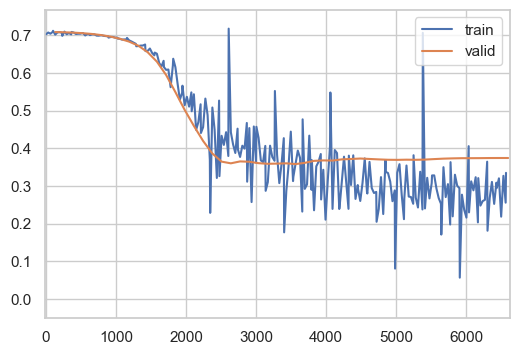

Fold: 1
acc: 0.5294
godbole_acc: 0.7458 / 0.7868 (chance)
lrap: 0.9287 / 0.7868 (chance)
f1: 0.8541
lrl: 0.1029
rec: 0.9439
prec: 0.7799
spec:  0.017241
cov_err: 6.8529
auroc: 0.5506
ap: 0.8355
fill_rate_pred: 0.9522 / 0.7868 (true)



train_loss,valid_loss,accuracy,f1
0.68982947,0.688072,0.227941,0.000000
0.69120216,0.687997,0.227941,0.000000
0.6898583,0.687877,0.227941,0.000000
0.69124365,0.687697,0.227941,0.000000
0.6881045,0.687452,0.227941,0.000000
0.68578464,0.687139,0.227941,0.000000
0.68218505,0.686735,0.227941,0.000000
0.6791518,0.686228,0.227941,0.000000
0.6766099,0.685672,0.227941,0.000000
0.66551566,0.685101,0.227941,0.000000


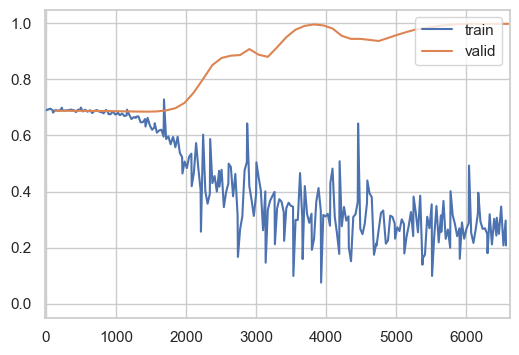

Fold: 2
acc: 0.5882
godbole_acc: 0.7511 / 0.7721 (chance)
lrap: 0.8718 / 0.7721 (chance)
f1: 0.8589
lrl: 0.1162
rec: 0.9714
prec: 0.7698
spec:  0.016129
cov_err: 7.1765
auroc: 0.5322
ap: 0.7782
fill_rate_pred: 0.9743 / 0.7721 (true)



train_loss,valid_loss,accuracy,f1
0.69623643,0.695504,0.129032,0.000000
0.6957816,0.694987,0.129032,0.000000
0.69689125,0.694171,0.129032,0.000000
0.69472927,0.692921,0.129032,0.000000
0.69400823,0.691123,0.129032,0.000000
0.6918906,0.688612,0.129032,0.000000
0.68829453,0.685235,0.129032,0.000000
0.6870083,0.680732,0.129032,0.000000
0.6844885,0.674748,0.129032,0.000000
0.6781112,0.666381,0.129032,0.000000


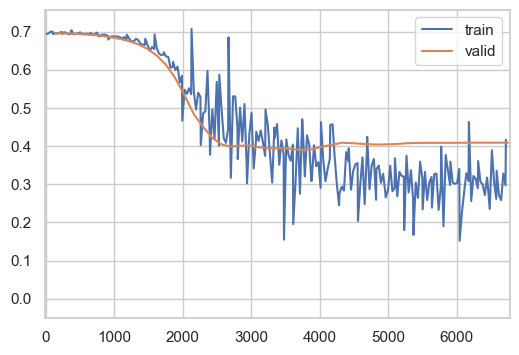

Fold: 3
acc: 0.5484
godbole_acc: 0.7702 / 0.8710 (chance)
lrap: 0.9566 / 0.8710 (chance)
f1: 0.8702
lrl: 0.0505
rec: 0.8843
prec: 0.8565
spec:  0.000000
cov_err: 7.3871
auroc: 0.5253
ap: 0.9038
fill_rate_pred: 0.8992 / 0.8710 (true)



train_loss,valid_loss,accuracy,f1
0.6917692,0.691459,0.196970,0.000000
0.6891952,0.691153,0.196970,0.000000
0.68916905,0.690663,0.196970,0.000000
0.6882456,0.689924,0.196970,0.000000
0.687188,0.688844,0.196970,0.000000
0.6886612,0.687368,0.196970,0.000000
0.6817067,0.685444,0.196970,0.000000
0.68320715,0.682769,0.196970,0.000000
0.6744517,0.679219,0.196970,0.000000
0.6666948,0.674141,0.196970,0.000000


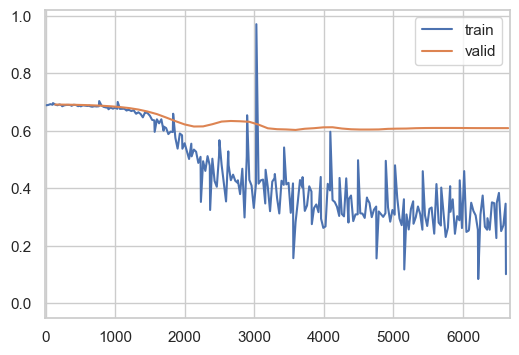

Fold: 4
acc: 0.6061
godbole_acc: 0.7462 / 0.8030 (chance)
lrap: 0.9234 / 0.8030 (chance)
f1: 0.8621
lrl: 0.0670
rec: 0.9292
prec: 0.8041
spec:  0.076923
cov_err: 6.9697
auroc: 0.4991
ap: 0.7806
fill_rate_pred: 0.9280 / 0.8030 (true)



train_loss,valid_loss,accuracy,f1
0.71149665,0.710738,0.216912,0.000000
0.71089536,0.710119,0.216912,0.000000
0.7082513,0.709124,0.216912,0.000000
0.7090472,0.707561,0.216912,0.000000
0.7078747,0.705199,0.216912,0.000000
0.7062003,0.701832,0.216912,0.000000
0.70197093,0.697026,0.216912,0.000000
0.6963992,0.689850,0.216912,0.000000
0.6880163,0.678945,0.216912,0.000000
0.6781284,0.662334,0.216912,0.000000


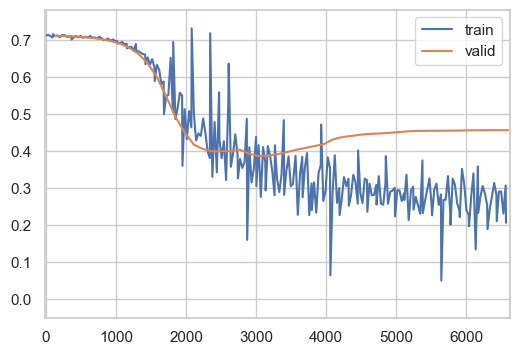

Fold: 5
acc: 0.6176
godbole_acc: 0.7537 / 0.7831 (chance)
lrap: 0.8703 / 0.7831 (chance)
f1: 0.8595
lrl: 0.1099
rec: 0.9624
prec: 0.7765
spec:  0.000000
cov_err: 7.0882
auroc: 0.3538
ap: 0.7138
fill_rate_pred: 0.9706 / 0.7831 (true)



model: RandomForestClassifier
acc: 0.6517 +/- 0.0344
godbole_acc: 0.7988 +/- 0.0257 / 0.8020 (chance level)
rec: 0.9944 +/- 0.0111
prec: 0.8037 +/- 0.0331
spec: 0.0065 +/- 0.0129
f1: 0.8884 +/- 0.0153
lrap: 0.8348 +/- 0.0263 / 0.8020 (chance level)
lrl: 0.1888 +/- 0.0309
cov_err: 7.5168 +/- 0.2017
auroc: 0.4985 +/- 0.0569
ap: 0.8030 +/- 0.0543 / 0.8020 (chance level)
fill_rate_pred: 0.9937 +/- 0.0094 / 0.8020 (true fill rate)


model: KNeighborsClassifier
acc: 0.5563 +/- 0.0676
godbole_acc: 0.7635 +/- 0.0421 / 0.8020 (chance level)
rec: 0.9466 +/- 0.0268
prec: 0.8012 +/- 0.0376
spec: 0.0442 +/- 0.0171
f1: 0.8673 +/- 0.0262
lrap: 0.8219 +/- 0.0346 / 0.8020 (chance level)
lrl: 0.2291 +/- 0.0385
cov_err: 7.6296 +/- 0.1635
auroc: 0.5031 +/- 0.0093
ap: 0.8050

In [47]:
res = train_and_eval_pytorch(mskf, model_partial, "TfIdfDense", ds)
results["TfIdfDense"]= res

for model, res in results.items():
    print("\n")
    print("=" * 80)
    print(f"model: {model}")
    print(
        f"acc: {np.mean(res['acc']):.4f} +/- {np.std(res['acc']):.4f}",
        f"godbole_acc: {np.mean(res['godbole_accs']):.4f} +/- {np.std(res['godbole_accs']):.4f} / {godbole_accuracy(y, np.ones_like(y), "macro"):.4f} (chance level)",
        f"rec: {np.mean(res['rec']):.4f} +/- {np.std(res['rec']):.4f}",
        f"prec: {np.mean(res['prec']):.4f} +/- {np.std(res['prec']):.4f}",
        f"spec: {np.mean(res['spec']):.4f} +/- {np.std(res['spec']):.4f}",
        f"f1: {np.mean(res['f1']):.4f} +/- {np.std(res['f1']):.4f}",
        f"lrap: {np.mean(res['lrap']):.4f} +/- {np.std(res["lrap"]):.4f} / {y.sum() / y.size:.4f} (chance level)",
        f"lrl: {np.mean(res['lrl']):.4f} +/- {np.std(res['lrl']):.4f}",
        f"cov_err: {np.mean(res['cov_err']):.4f} +/- {np.std(res['cov_err']):.4f}",
        f"auroc: {np.mean(res['auroc']):.4f} +/- {np.std(res['auroc']):.4f}",
        f"ap: {np.mean(res['ap']):.4f} +/- {np.std(res['ap']):.4f} / {average_precision_score(y, np.ones_like(y), average='macro'):.4f} (chance level)",
        f"fill_rate_pred: {np.mean(res['fill_rate_preds']):.4f} +/- {np.std(res['fill_rate_preds']):.4f} / {np.sum(y) / y.size:.4f} (true fill rate)",
        "=" * 80,
        sep="\n",
        end="\n",
    )

best_model = max(results.items(), key=lambda x: x[1]["f1"])
print(f"Best model: {best_model[0]}, F1: {np.mean(best_model[1]['f1']):.4f}")

# Results

In [48]:
results_for_df = {}

for model_name, result in results.items():
    if "model" not in results_for_df:
        results_for_df["model"] = []
    results_for_df["model"].append(model_name)
    for metric, values in result.items():
        if metric in ["y_pred", "y", "y_prob", "mlm"]:
            continue
        mean = np.mean(values)
        std = np.std(values)
        if metric not in results_for_df:
            results_for_df[metric] = []
        results_for_df[metric].append(mean)
        if f"{metric}_std" not in results_for_df:
            results_for_df[f"{metric}_std"] = []
        results_for_df[f"{metric}_std"].append(std)

In [49]:
results_df = pd.DataFrame.from_dict(results_for_df)

In [50]:
pd.set_option("display.max_columns", None)

In [51]:
results_df

,model,acc,acc_std,godbole_accs,godbole_accs_std,f1,f1_std,rec,rec_std,prec,prec_std,spec,spec_std,lrap,lrap_std,lrl,lrl_std,cov_err,cov_err_std,auroc,auroc_std,ap,ap_std,fill_rate_preds,fill_rate_preds_std
0,RandomForestClassifier,0.651739,0.034427,0.798833,0.025695,0.888359,0.015269,0.994444,0.011111,0.803686,0.033133,0.006452,0.012903,0.834776,0.026288,0.188802,0.030942,7.516796,0.201701,0.498457,0.056863,0.803006,0.054293,0.993691,0.009385
1,KNeighborsClassifier,0.556339,0.067622,0.763506,0.042058,0.867333,0.026221,0.946573,0.026790,0.801234,0.037581,0.044225,0.017081,0.821939,0.034612,0.229128,0.038491,7.629630,0.163542,0.503125,0.009329,0.804970,0.034137,0.948883,0.022771
2,DecisionTreeClassifier,0.483083,0.066135,0.695054,0.057703,0.830702,0.039844,0.853057,0.078328,0.814623,0.042523,0.214525,0.082712,0.802628,0.035478,0.315468,0.048758,7.916543,0.046501,0.483263,0.028516,0.798930,0.032767,0.840562,0.067224
3,MLPClassifier,0.561831,0.045367,0.757552,0.032091,0.863429,0.018294,0.938943,0.018128,0.800278,0.035866,0.043721,0.024447,0.883760,0.031037,0.102904,0.027752,7.112857,0.146421,0.541816,0.049626,0.828578,0.054499,0.942391,0.018650
4,TfIdfDense,0.577948,0.033769,0.753380,0.008899,0.860983,0.005270,0.938260,0.030706,0.797367,0.031751,0.022059,0.028431,0.910163,0.033865,0.089339,0.025834,7.094888,0.182372,0.492194,0.071151,0.802391,0.063712,0.944857,0.028104


In [29]:
np.sum(y) / y.size

0.8019578313253012

In [36]:
best_model_outputs = []
for i in range(NUM_FOLDS):
    results = {
        "y_pred": best_model[1]["y_pred"][i],
        "y_prob": best_model[1]["y_prob"][i],
        "y": best_model[1]["y"][i],
    }
    best_model_outputs.append(results)

  0%|          | 0/5 [00:00<?, ?it/s]

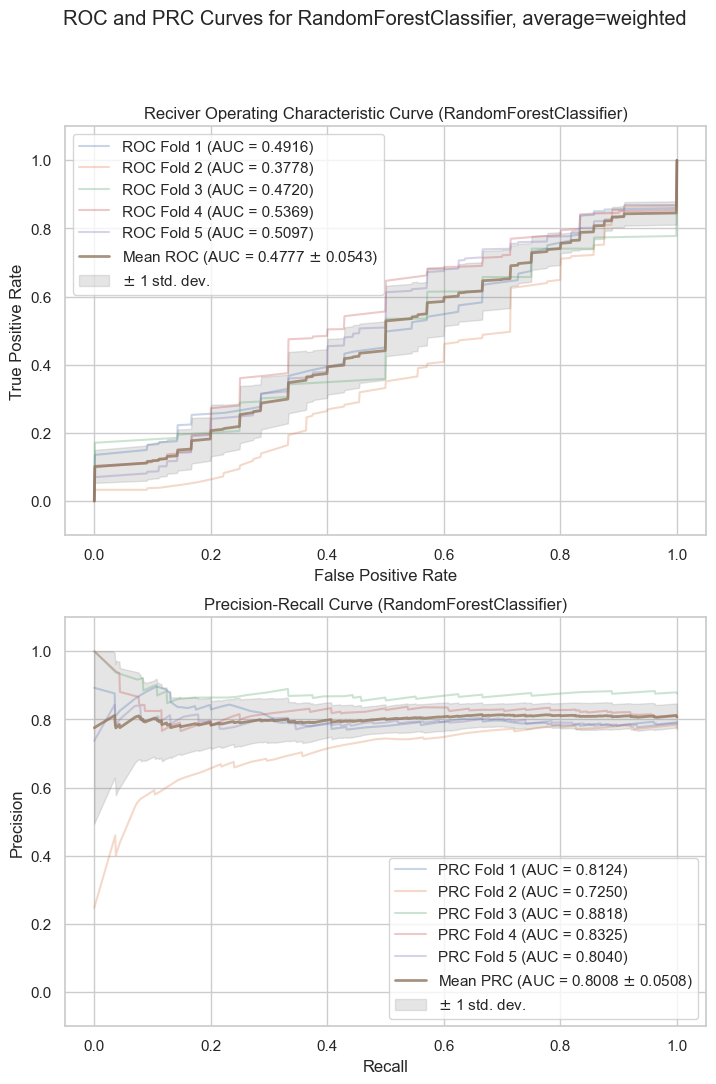

In [37]:
k_fold_roc_curve(
    best_model_outputs,
    best_model[0],
    len(df.columns[2:-1]),
    "weighted",
)

In [52]:
model_outputs = []
for model_name, result in results.items():
    current_model_outputs = []
    for i in range(NUM_FOLDS):
        fold_results = {
            "y_pred": result["y_pred"][i],
            "y_prob": result["y_prob"][i],
            "y": result["y"][i],
        }
        current_model_outputs.append(fold_results)
    model_outputs.append(current_model_outputs)

  0%|          | 0/5 [00:00<?, ?it/s]

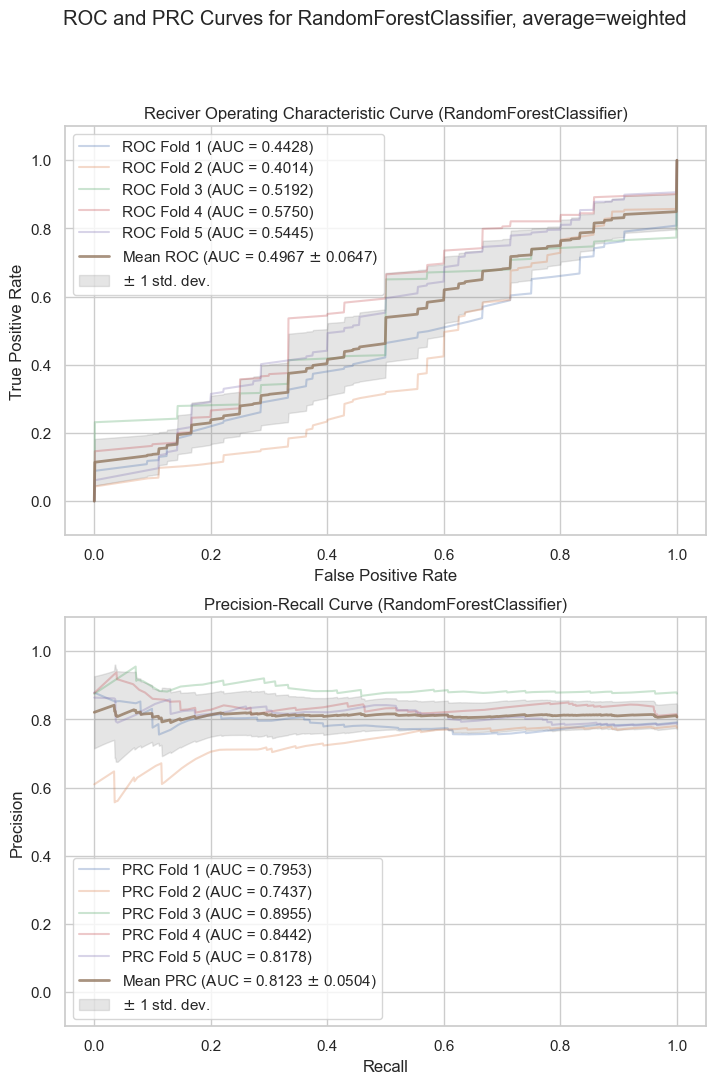

  0%|          | 0/5 [00:00<?, ?it/s]

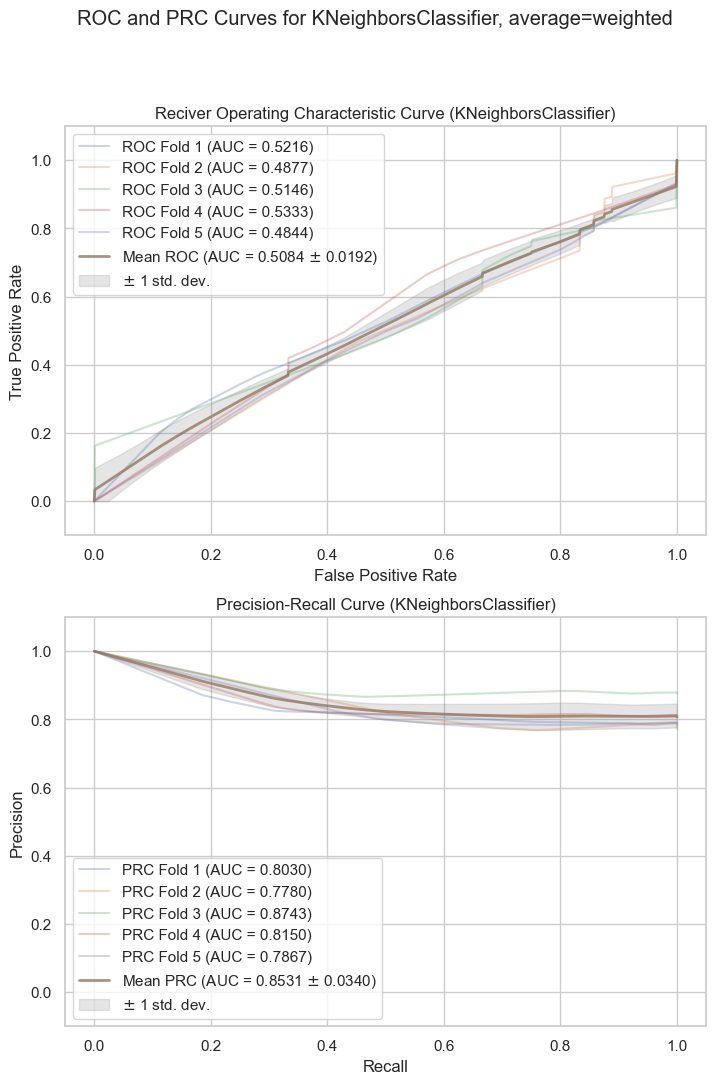

  0%|          | 0/5 [00:00<?, ?it/s]

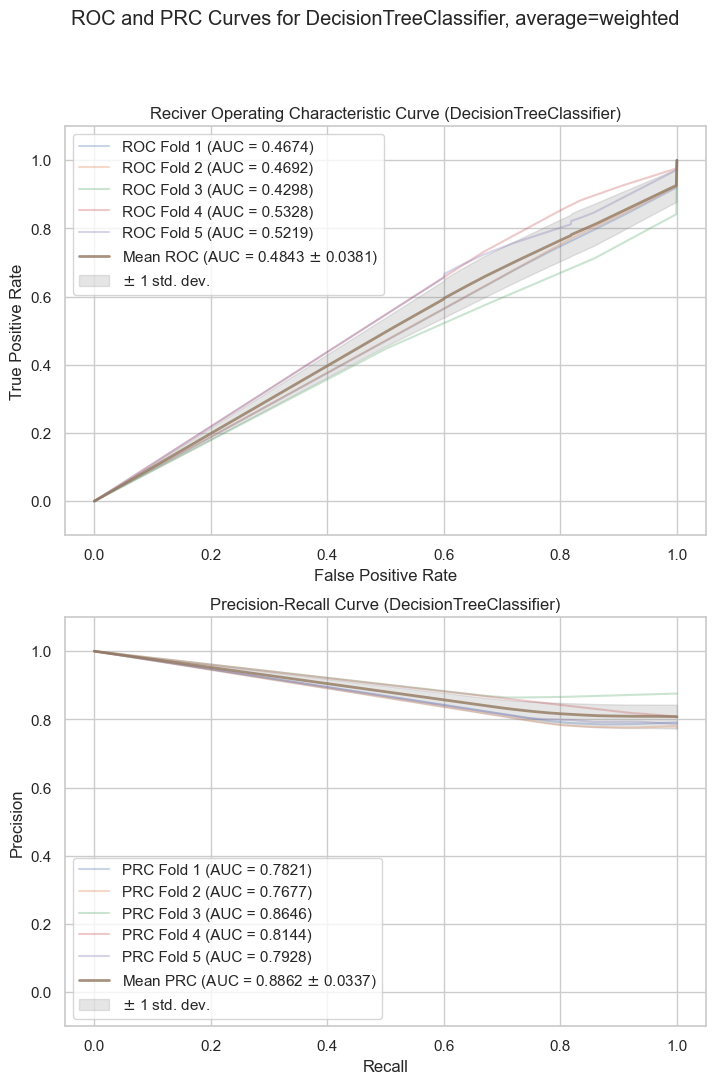

  0%|          | 0/5 [00:00<?, ?it/s]

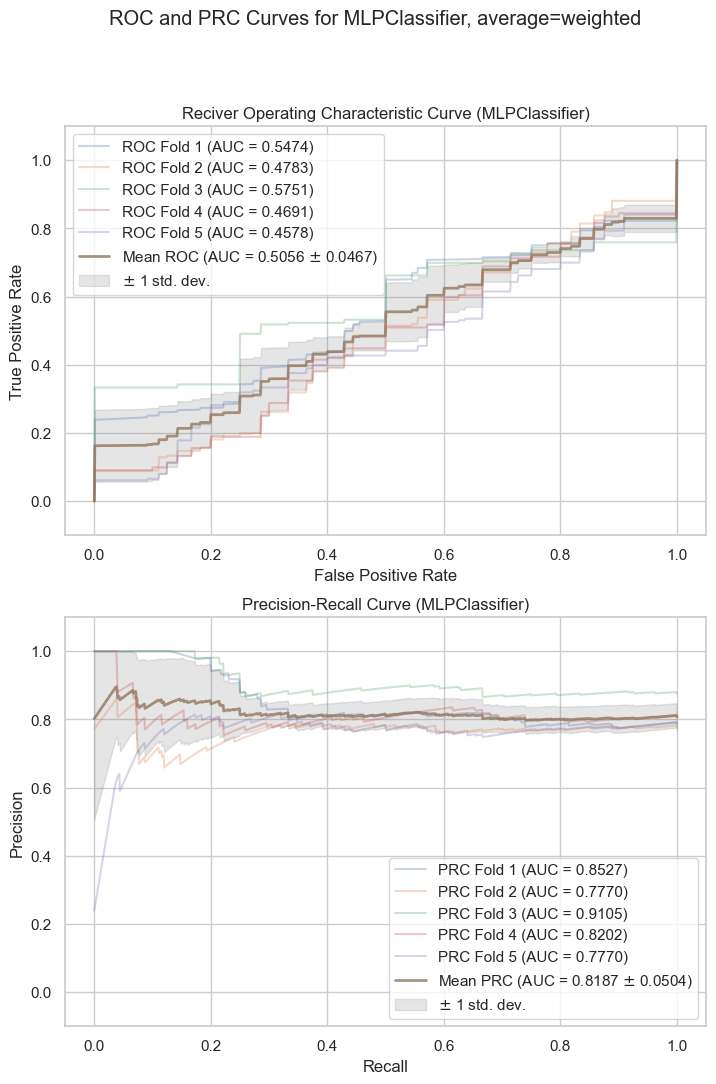

  0%|          | 0/5 [00:00<?, ?it/s]

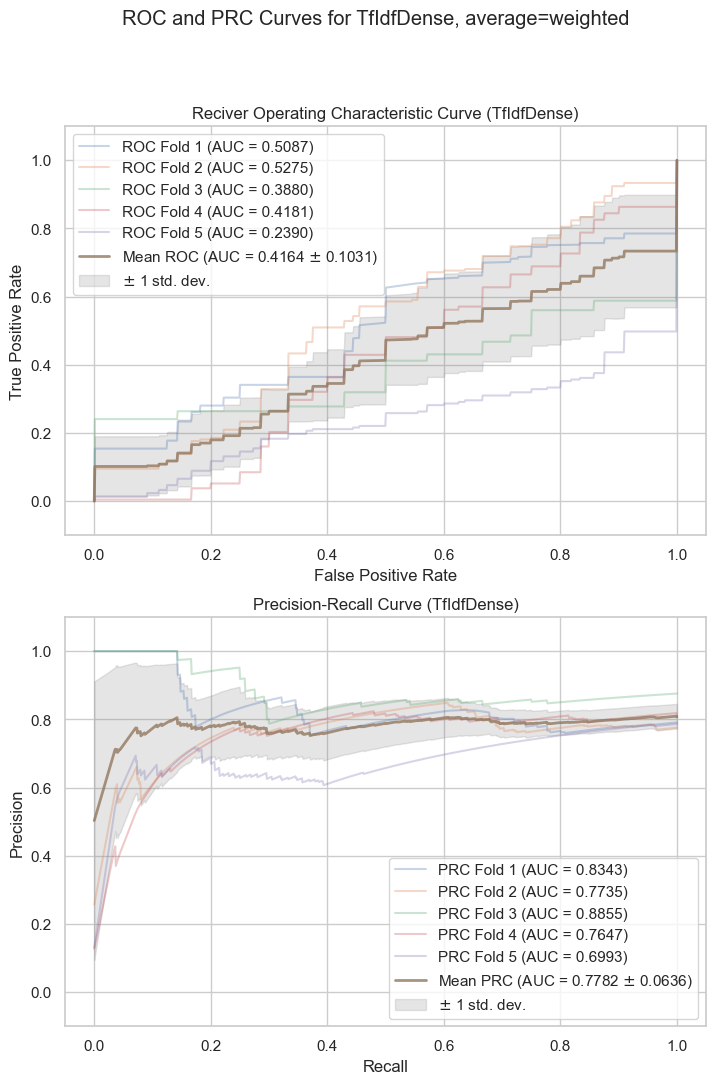

In [53]:
for i, model_output in enumerate(model_outputs):
    model_name = list(results.keys())[i]
    k_fold_roc_curve(
        model_output,
        model_name,
        len(df.columns[2:-1]),
        "weighted",
    )

# Old dl

In [14]:
model_partial = partial(
    TfIdfAttention,
    n_inputs=PADDED_SIZE,
    n_outputs=len(df.columns[2:-1]),
    embed_size=PADDED_SIZE // NUM_HEADS,
    hidden_size=[32],
    n_heads=NUM_HEADS,
    dropout=0.2
)